# Compute fst within the 3R chrom

In [ ]:
!pip install -q malariagen_data
!pip install -q scikit-allel
!pip install -q petl

### importing necessary package

In [2]:
import allel
import malariagen_data
import numpy as np
import pandas as pd
import dask
import dask.array as da
# silence some dask warnings
dask.config.set(**{'array.slicing.split_large_chunks': True})
from dask.diagnostics.progress import ProgressBar

In [3]:
import random
import functools
import petl as ptl
import itertools
import scipy
from collections import Counter

In [4]:
# plotting setup
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import matplotlib_venn as venn
import seaborn as sns

In [5]:
#Mounting Google Drive
import os
from google.colab import drive
drive.mount("drive")

# make dir 
results_dir = "drive/MyDrive/Genomic/graph"
os.makedirs(results_dir, exist_ok=True)

Mounted at drive


Importing malariagen data set    
Let's select the the sample set from 

In [6]:
ag3 = malariagen_data.Ag3("gs://vo_agam_release/", pre=True)
#ag3
sets = ["1191-VO-MULTI-OLOUGHLIN-VMF00106", "1191-VO-MULTI-OLOUGHLIN-VMF00140", 
             "AG1000G-BF-A", "AG1000G-BF-B", "AG1000G-BF-C"]
df_samples = ag3.sample_metadata(sample_sets=sets)#.set_index("sample_id")
bf_samples = df_samples.query('country == "Burkina Faso"')
#bf_samples.groupby(['location', 'aim_species']).size()

#To access to the genotypes within the 3R chromosomes
chrom3R_gt = ag3.snp_calls(region="3R", sample_sets=sets)

# Take some SNP in the 3R chromosomes 
snps_pos = allel.SortedIndex(chrom3R_gt['variant_position'].values)

Load sample metadata:   0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
from collections import Counter

#Create population column 
bf_samples = df_samples.query('country == "Burkina Faso" and year > 2004')
s1, s2, s3, y, sp_y, pop_labels, pop_colors, sp_labels, sp_colors = [], [], [], [], [], {}, {}, {}, {}
for iso, species in zip(bf_samples.location, bf_samples.aim_species):
    s1.append(iso[:4]+'_'+species[:3])
bf_samples.insert(4, 'population', s1)
bf_samples_sel = pd.concat([bf_samples, bf_samples])
pop_ids = list(bf_samples.population.unique())

# Pop_year 
for pop, year in zip(bf_samples.population, bf_samples.year):
    y.append(pop+'_'+str(year))
bf_samples.insert(5, 'pop_year', y)
pop_year = list(bf_samples.pop_year.unique())

# Species_year 
for species, year in zip(bf_samples.aim_species, bf_samples.year):
    sp_y.append(species+'_'+str(year))
bf_samples.insert(6, 'species_year', sp_y)
species_year = list(bf_samples.species_year.unique())

#pop_id
for idx, species in zip(bf_samples.location, bf_samples.aim_species):
  w = idx.split(' ')[0][:14]
  s2.append(w+' $An.'+species)
val = list(Counter(s2).keys())
for idx, vl in zip(pop_ids, val):
    pop_labels[idx]=vl
pop_labels

#sp labels 
for year, species in zip(bf_samples.year, bf_samples.aim_species):
  s3.append(str(year)+' $An.'+species)
val = list(Counter(s3).keys())
for idx, vl in zip(species_year, val):
    sp_labels[idx]=vl
sp_labels

#pop_labels color
colored = sns.color_palette("husl", len(pop_ids))
for i in range(len(pop_ids)):
    pop_colors[pop_ids[i]] = colored[i]

#sp_labels color
colored = sns.color_palette("husl", len(species_year))
for i in range(len(species_year)):
    sp_colors[species_year[i]] = colored[i]

#pop_cohort
coh_pop = dict([(f"{p}", list(df.index)) for (p), df in bf_samples.reset_index().groupby(['population'])])
coh_pop_year = dict([(f"{p}", list(df.index)) for (p), df in bf_samples.reset_index().groupby(['pop_year'])])
coh_species_year = dict([(f"{p}", list(df.index)) for (p), df in bf_samples.reset_index().groupby(['species_year'])])

#remove some populations 
pop_rm = ['Bana_ara', 'Bana_int', 'Sour_ara', 'Mono_gam', 'Pala_col']
pop_year_rm = ['Bana_col_2012', 'Bana_col_2014', 'Bana_col_2015', 'Bana_col_2016', 
               'Bana_col_2017', 'Bana_gam_2012', 'Bana_gam_2014', 'Bana_gam_2015', 'Bana_gam_2016', 
               'Pala_ara_2014', 'Pala_ara_2015', 'Pala_ara_2016', 'Pala_col_2012', 
               'Pala_gam_2012', 'Pala_gam_2014', 'Pala_gam_2015', 'Pala_gam_2016', 'Pala_gam_2017', 
               'Sour_col_2012', 'Sour_col_2014', 'Sour_col_2015', 'Sour_col_2016', 
               'Sour_col_2017', 'Sour_gam_2012', 'Sour_gam_2014', 'Sour_gam_2015', 'Sour_gam_2016']
del s1, s2, y, val, colored, sp_y
pop_species_year = ['arabiensis_2014', 'arabiensis_2015', 'arabiensis_2016', 'arabiensis_2017', 
                    'coluzzii_2012', 'coluzzii_2014', 'coluzzii_2015', 'coluzzii_2016', 'coluzzii_2017', 
                    'gambiae_2012', 'gambiae_2014', 'gambiae_2015', 'gambiae_2016', 'gambiae_2017']
pop_species_year_select = ['arabiensis_2014', 'arabiensis_2015', 'arabiensis_2016','coluzzii_2012', 
                           'coluzzii_2014', 'coluzzii_2015', 'coluzzii_2016', 'coluzzii_2017', 
                           'gambiae_2012', 'gambiae_2014', 'gambiae_2015', 'gambiae_2016', 'gambiae_2017']

In [8]:
#bf_samples.groupby(['aim_species', 'species_year', 'year']).size()

In [9]:
#To the genomics dataset of bf samples 
bf_snps = chrom3R_gt.sel(samples=df_samples.eval('country=="Burkina Faso"'))

# Take some SNP in the 3R chromosomes 
bf_snps_pos = allel.SortedIndex(bf_snps['variant_position'].values)

# To filter the SNP dataset and warp the dataset to GT array 
filt = 'gamb_colu_arab' 
filt_val = bf_snps[f"variant_filter_pass_{filt}"].values 
filtered_pos = allel.SortedIndex(bf_snps['variant_position'][filt_val].values)
gt_filtered = allel.GenotypeDaskArray(bf_snps["call_genotype"][filt_val].data)


In [10]:
filterd_val = bf_snps[f"variant_filter_pass_{filt}"].values 
#filtered_pos

In [11]:
# compute allele counts  
#with ProgressBar():
  #ac = gt_filtered.count_alleles(max_allele=3).compute()
  #ac_pop = gt_filtered.count_alleles_subpops(coh_pop)

ac_pop_year = {} ## compute allele counts pop - dict
with ProgressBar():
  for pop in pop_species_year:
    ac_pop_year[pop] = gt_filtered.take(coh_species_year[pop],axis=1).count_alleles(max_allele=3).compute()

[########################################] | 100% Completed |  4min 42.7s
[########################################] | 100% Completed |  8min 22.0s
[########################################] | 100% Completed |  2min 20.8s
[########################################] | 100% Completed |  1min  1.7s
[########################################] | 100% Completed |  4min 33.8s
[########################################] | 100% Completed |  7min 47.0s
[########################################] | 100% Completed |  9min 17.2s
[########################################] | 100% Completed |  7min 26.6s
[########################################] | 100% Completed |  6min 20.7s
[########################################] | 100% Completed |  4min  1.1s
[########################################] | 100% Completed |  6min 38.3s
[########################################] | 100% Completed |  8min 41.6s
[########################################] | 100% Completed |  5min 21.0s
[#####################################

# Fst

In [12]:
@functools.lru_cache(maxsize=None)
def load_ac(pop):
    ac_popi = ac_pop_year[pop]
    return ac_popi
#load_ac(pop='Bana_col')

In [13]:
@functools.lru_cache(maxsize=None)
def compute_pair_fst(pops, blen=10000):
    # order is irrelevant
    pop1, pop2 = pops
    ac_pop1 = load_ac(pop=pop1)
    ac_pop2 = load_ac(pop=pop2)
    loc_pass = ac_pop1.is_segregating() & ac_pop2.is_segregating() & (ac_pop1.max_allele() <= 1) & (ac_pop2.max_allele() <= 1)
    ac1 = ac_pop1[loc_pass]
    ac2 = ac_pop2[loc_pass]
    
    # compute Fst
    fst, se, _, _ = allel.blockwise_hudson_fst(ac1, ac2, blen)
    
    return fst, se

In [14]:
def compute_pairwise_fst(pop_coh, blen=10000):
    pairwise_fst = []
    pairwise_fst_se = []
    for pop1, pop2 in itertools.combinations(pop_coh, 2):
        pops = tuple(sorted([pop1, pop2]))
        fst, se = compute_pair_fst(pops=pops, blen=blen)
        pairwise_fst.append(fst)
        pairwise_fst_se.append(se)
    return pairwise_fst, pairwise_fst_se

In [15]:
def tabulate_pairwise_fst(pop_coh, blen=10000):
    fst, se = compute_pairwise_fst(pop_coh, blen=blen)
    fstsq = scipy.spatial.distance.squareform(fst)
    sesq = scipy.spatial.distance.squareform(se)
    data = [zip(r1, r2) for r1, r2 in zip(fstsq, sesq)]
    tbl_fst = (ptl
               .wrap(data)
               .pushheader(pop_coh)
               .convertall(lambda v: '' if v == (0, 0) else '%.04f (%.04f)' % v)
               .addcolumn('population', pop_coh, index=0)
               )
    tbl_fst.displayall(index_header=False, caption='Fst (standard error)')

In [16]:
def plot_pairwise_fst_z(fst, se, pop_coh, figsize=(7, 4), mask=True,ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        sns.despine(ax=ax, top=False, bottom=True, offset=0)

    # plot Fst
    data = scipy.spatial.distance.squareform(fst).copy()
    pop_indices = [pop_coh.index(p) for p in pop_coh]
    data = data.take(pop_indices, axis=0).take(pop_indices, axis=1)
    data[data < 0] = 0
    mask = np.zeros_like(data)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(data, ax=ax, vmin=0, cmap=(sns.light_palette((210, 90, 60), input="husl")), 
                mask=mask, cbar=False, annot=True, fmt='.2f', )

    # plot Z score
    data = scipy.spatial.distance.squareform(np.array(fst)/np.array(se)).copy()
    data = data.take(pop_indices, axis=0).take(pop_indices, axis=1)
    data[data < 0] = 0
    mask = np.zeros_like(data)
    mask[np.tril_indices_from(mask)] = True
    sns.heatmap(data, ax=ax, vmin=0, vmax=100, cmap='Greys', 
                mask=mask, cbar=False, annot=True, fmt='.1f', )
    
    xtl = [pop_labels[p] for p in pop_coh]
    ytl = list(xtl)#[::-1]
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(len(xtl)) + .5)
    ax.set_xticklabels(xtl, rotation=45, ha='left', fontweight='bold')
    ax.set_yticklabels(ytl, rotation=0, ha='right', fontweight='bold')
    ax.tick_params(length=0, pad=3)
    ax.set_xlabel('Chrom 3R - $F_{ST}$')
    ax.set_ylabel('$Z$ score')
    ax.yaxis.set_label_position('right')
    return ax

In [17]:
def plot_pairwise_fst(fst, se, pop_coh, pop_labels, figsize=(7, 4), mask=True, ax=None, 
                      fig_name=None):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        sns.despine(ax=ax, top=False, bottom=True, offset=0)

    # plot Fst
    data = scipy.spatial.distance.squareform(fst).copy()
    pop_indices = [pop_coh.index(p) for p in pop_coh]
    data = data.take(pop_indices, axis=0).take(pop_indices, axis=1)
    data[data < 0] = 0
    mask = np.zeros_like(data)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(data, ax=ax, vmin=0, cmap=(sns.light_palette((210, 90, 60), input="husl")), 
                mask=mask, cbar=False, annot=True, fmt='.4f', )

    # plot Z score
    data = scipy.spatial.distance.squareform(np.array(fst)/np.array(se)).copy()
    data = data.take(pop_indices, axis=0).take(pop_indices, axis=1)
    data[data < 0] = 0
    mask = np.zeros_like(data)
    mask[np.tril_indices_from(mask)] = True
    sns.heatmap(data, ax=ax, vmin=0, vmax=100, cmap='Greys', 
                mask=mask, cbar=False, annot=True, fmt='.1f', )
    
    xtl = [pop_labels[p] for p in pop_coh]
    ytl = list(xtl)#[::-1]
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(len(xtl)) + .5)
    ax.set_xticklabels(xtl, rotation=45, ha='left', fontweight='bold')
    ax.set_yticklabels(ytl, rotation=0, ha='right', fontweight='bold')
    ax.tick_params(length=0, pad=3)
    ax.set_xlabel('Chrom 3R - $F_{ST}$')
    ax.set_ylabel('$Z$ score')
    ax.yaxis.set_label_position('right')

    # Save fig
    if fig_name:
      fig.savefig(f"drive/MyDrive/Genomic/Fst/{fig_name}.png", dpi=300, bbox_inches='tight')

In [18]:
## Define function to compute window pair_fst
#@functools.lru_cache(maxsize=None)
def compute_windowed_pair_fst(pops, filt_pos, size):
    # order is irrelevant
    pop1, pop2 = pops
    ac_pop1 = load_ac(pop=pop1)
    ac_pop2 = load_ac(pop=pop2)
    loc_pass = ac_pop1.is_segregating() & ac_pop2.is_segregating() & (ac_pop1.max_allele() <= 1) & (ac_pop2.max_allele() <= 1)
    # Find selected SNPs pos
    pos=filt_pos[loc_pass]
    # compute windowed_fst
    fst_wind,windows,counts = allel.windowed_hudson_fst(pos, ac_pop1[loc_pass], ac_pop2[loc_pass],size=size)
    return fst_wind,windows,counts 
  
def compute_windowed_pairwise_fst(coh_list, pos_filt, size):
    pairwise_fst = {}
    wind_pairwise_fst = {}
    for pop1, pop2 in itertools.combinations(coh_list, 2):
        pops = tuple(sorted([pop1, pop2]))
        fst, wind, _ = compute_windowed_pair_fst(pops=pops,filt_pos=pos_filt,size=size)
        pairwise_fst[f'fst_{pop1}_{pop2}'] = fst
        wind_pairwise_fst[f'wind_{pop1}_{pop2}'] = wind
    return pairwise_fst, wind_pairwise_fst

#### Year to year Fst between An. gambiae ss populations 


In [19]:
gamb = ['gambiae_2012', 'gambiae_2014', 'gambiae_2015', 'gambiae_2016', 'gambiae_2017']
fst_gamb, se_gamb = compute_pairwise_fst(gamb, blen=100000)
#plot_pairwise_fst(fst=fst_gamb, se=se_gamb, pop_coh=gamb, pop_labels=sp_labels)

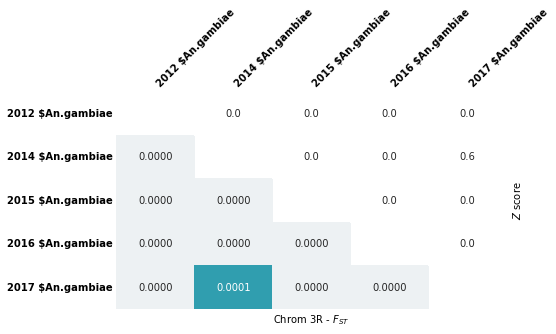

In [20]:
plot_pairwise_fst(fst=fst_gamb, se=se_gamb, pop_coh=gamb, pop_labels=sp_labels, fig_name='Ag_3R_yty_fst')

In [21]:
# compute fst and windows
gamb = ['gambiae_2012', 'gambiae_2014', 'gambiae_2015', 'gambiae_2016', 'gambiae_2017']
fst_dict_ag, wind_fst_dict_ag = compute_windowed_pairwise_fst(coh_list=gamb, pos_filt=filtered_pos, size=100000) 
# warp fst data to dataframe
df_fst=pd.DataFrame(fst_dict_ag)
df_wind=pd.DataFrame(np.mean(wind_fst_dict_ag['wind_gambiae_2012_gambiae_2014'], axis=1), columns=['wind_mean'])
data_fst_ag=pd.concat([df_wind, df_fst], axis=1)
ag_fst = data_fst_ag.copy()
ag_fst[ag_fst<0]=0
print('done')

# Warp to df
data_fst_ag = ag_fst.melt('wind_mean', var_name='year_Pop', value_name='pair_fst')
xlim1 = list(ag_fst.wind_mean)

done


In [22]:
def plot_fst_year(data=data_fst_ag, figsize=(12,4), ax=None, title = None, xlab=None,
                  ylab=None, legend_loc=None, fig_name=None):

  if ax is None:
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine(ax=ax, offset=5)
  
  #Plot fst
  sns.lineplot(x = 'wind_mean', y = 'pair_fst', hue='year_Pop', data=data, ax=ax,  linewidth=.5)
  
  # set ax title
  if title:
    ax.set_title (title = f'{title}')
  if xlab:
    ax.set_xlabel(f'{xlab}')
  if ylab:
    ax.set_ylabel(f'{ylab}')

  #set legend
  if legend_loc:
    ax.legend(loc='best', bbox_to_anchor=legend_loc)
  
  # set ax lim
  xlim=[xlim1[0], xlim1[-1]]
  ax.set_ylim(0,0.25)
  ax.set_xlim(*xlim)
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])

  # Save fig
  if fig_name:
    fig.savefig(f"drive/MyDrive/Genomic/Fst/{fig_name}.png", dpi=300, bbox_inches='tight')

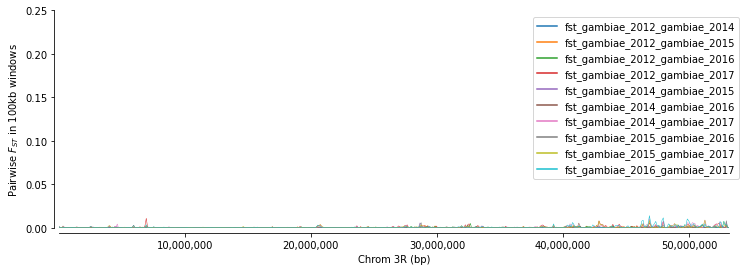

In [23]:
## Compute An. gambiae Fst 
fig, ax = plt.subplots(figsize=(12, 4))
sns.despine(ax=ax, offset=5)
plot_fst_year(data=data_fst_ag, ax=ax, xlab='Chrom 3R (bp)', ylab='Pairwise $F_{ST}$ in 100kb windows', 
              legend_loc=(0.7, 0.2))

#ax.axvspan(48703664, 48792262, color='magenta', alpha=0.2, lw=0.3)
#ax.annotate('$dsx$ region', xy=(48792262, 0.01), xytext=(46792262, 0.08), color='darkred',
#            arrowprops=dict(arrowstyle="->", color='slategrey'))
    
#ax.axvspan(28491242, 28493314, color='magenta', alpha=0.2, lw=0.3)
#ax.annotate('$Cyp6p$ region', xy=(28493314, 0.13), xytext=(25493314, 0.2), color='darkred',
#            arrowprops=dict(arrowstyle="->", color='slategrey'))
    
#ax.axvspan(3438301, 3497400, color='magenta', alpha=0.2, lw=0.3)
#ax.annotate('$Ace1R$ region', xy=(3497400, 0.11), xytext=(1007400, 0.18), color='darkred',
#            arrowprops=dict(arrowstyle="->", color='slategrey'))

# Save fig
fig.savefig(f"drive/MyDrive/Genomic/Fst/Ag_3R_window_yty_fst.png", dpi=300, bbox_inches='tight')

### Year to Year Fst between An. coluzzii population 

In [24]:
coluzzii = ['coluzzii_2012', 'coluzzii_2014', 'coluzzii_2015', 'coluzzii_2016', 'coluzzii_2017']
fst_coluzzii, se_coluzzii = compute_pairwise_fst(coluzzii, blen=100000)
#plot_pairwise_fst(fst=fst_coluzzii, se=se_coluzzii, pop_coh=coluzzii, pop_labels=sp_labels)

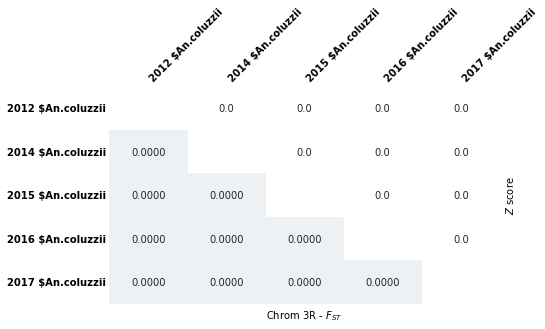

In [25]:
plot_pairwise_fst(fst=fst_coluzzii, se=se_coluzzii, pop_coh=coluzzii, pop_labels=sp_labels, fig_name='Ac_3R_yty_fst')

In [26]:
# compute fst and windows
coluzzii = ['coluzzii_2012', 'coluzzii_2014', 'coluzzii_2015', 'coluzzii_2016', 'coluzzii_2017']
fst_dict_ac, wind_fst_dict_ac = compute_windowed_pairwise_fst(coh_list=coluzzii, pos_filt=filtered_pos, size=100000) 
# warp fst data to dataframe
df_fst=pd.DataFrame(fst_dict_ac)
df_wind=pd.DataFrame(np.mean(wind_fst_dict_ac['wind_coluzzii_2012_coluzzii_2014'], axis=1), columns=['wind_mean'])
data_fst_ac=pd.concat([df_wind, df_fst], axis=1)
ac_fst = data_fst_ac.copy()
ac_fst[ac_fst<0]=0
print('done')

# Warp to df
data_fst_ac = ac_fst.melt('wind_mean', var_name='year_Pop', value_name='pair_fst')
xlim1 = list(ac_fst.wind_mean)

done


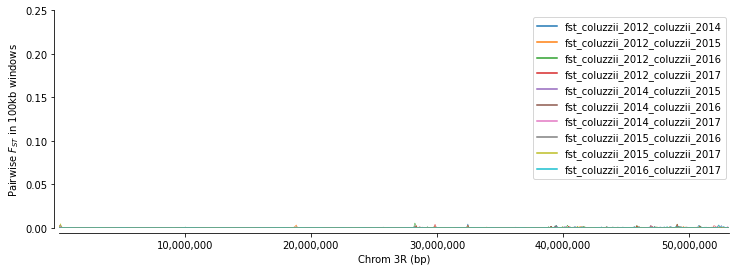

In [27]:
# Compute An. coluzzii Fst 
fig, ax = plt.subplots(figsize=(12, 4))
sns.despine(ax=ax, offset=5)
plot_fst_year(data=data_fst_ac, ax=ax, xlab='Chrom 3R (bp)', ylab='Pairwise $F_{ST}$ in 100kb windows', 
              legend_loc=(0.7, 0.2))

#ax.axvspan(48703664, 48792262, color='magenta', alpha=0.2, lw=0.3)
#ax.annotate('$dsx$ region', xy=(48792262, 0.01), xytext=(46792262, 0.08), color='darkred',
#            arrowprops=dict(arrowstyle="->", color='slategrey'))
    
#ax.axvspan(28491242, 28493314, color='magenta', alpha=0.2, lw=0.3)
#ax.annotate('$Cyp6p$ region', xy=(28493314, 0.04), xytext=(25493314, 0.1), color='darkred',
#            arrowprops=dict(arrowstyle="->", color='slategrey'))
    
#ax.axvspan(3438301, 3497400, color='magenta', alpha=0.2, lw=0.3)
#ax.annotate('$Ace1R$ region', xy=(3497400, 0.01), xytext=(1007400, 0.1), color='darkred',
#            arrowprops=dict(arrowstyle="->", color='slategrey'))

# Save fig
fig.savefig(f"drive/MyDrive/Genomic/Fst/Ac_3R_window_yty_fst.png", dpi=300, bbox_inches='tight')

### Year to Year Fst between *An. arabiensis* population 

In [28]:
arabiensis = ['arabiensis_2014', 'arabiensis_2015', 'arabiensis_2016']
fst_arabiensis, se_arabiensis = compute_pairwise_fst(arabiensis, blen=100000)
#plot_pairwise_fst(fst=fst_arabiensis, se=se_arabiensis, pop_coh=arabiensis, pop_labels=sp_labels)

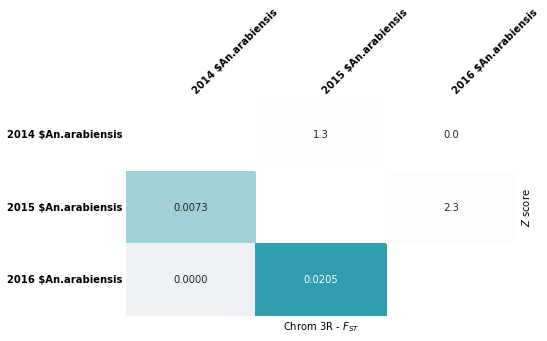

In [29]:
plot_pairwise_fst(fst=fst_arabiensis, se=se_arabiensis, pop_coh=arabiensis, pop_labels=sp_labels, fig_name='Aa_3R_yty_fst')

In [30]:
# compute fst and windows
arabiensis = ['arabiensis_2014', 'arabiensis_2015', 'arabiensis_2016']
fst_dict_aa, wind_fst_dict_aa = compute_windowed_pairwise_fst(coh_list=arabiensis, pos_filt=filtered_pos, size=100000) 
# warp fst data to dataframe
df_fst=pd.DataFrame(fst_dict_aa)
df_wind=pd.DataFrame(np.mean(wind_fst_dict_aa['wind_arabiensis_2014_arabiensis_2015'], axis=1), columns=['wind_mean'])
data_fst_aa=pd.concat([df_wind, df_fst], axis=1)
aa_fst = data_fst_aa.copy()
aa_fst[aa_fst<0]=0
print('done')

# Warp to df
data_fst_aa = aa_fst.melt('wind_mean', var_name='year_Pop', value_name='pair_fst')
xlim1 = list(aa_fst.wind_mean)

done


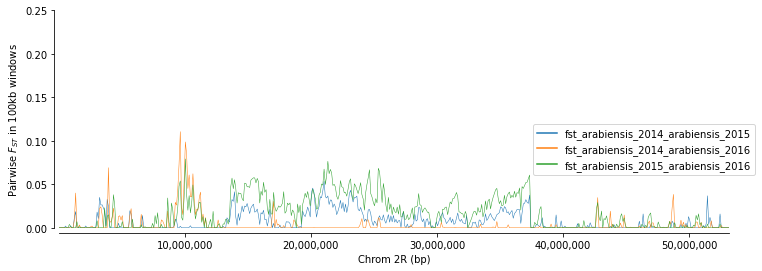

In [31]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.despine(ax=ax, offset=5)
plot_fst_year(data=data_fst_aa, ax=ax, xlab='Chrom 2R (bp)', ylab='Pairwise $F_{ST}$ in 100kb windows', 
              legend_loc=(0.7, 0.5))

#ax.axvspan(48703664, 48792262, color='magenta', alpha=0.2, lw=0.3)
#ax.annotate('$dsx$ region', xy=(48792262, 0.3), xytext=(50000000, 0.3), color='darkred',
#            arrowprops=dict(arrowstyle="->", color='crimson'))
    
#ax.axvspan(28491242, 28493314, color='magenta', alpha=0.2, lw=0.3)
#ax.annotate('$Cyp6p$ region', xy=(28493314, 0.74), xytext=(30000000, 0.3), color='darkred',
#            arrowprops=dict(arrowstyle="->", color='crimson'))
    
#ax.axvspan(3438301, 3497400, color='magenta', alpha=0.2, lw=0.3)
#ax.annotate('$Ace1R$ region', xy=(3497400, 0.15), xytext=(4500000, 0.3), color='darkred',
#            arrowprops=dict(arrowstyle="->", color='crimson'))

# Save fig
fig.savefig(f"drive/MyDrive/Genomic/Fst/Aa_2R_window_yty_fst.png", dpi=300, bbox_inches='tight')

##Conclusion  
These results showed a weak year to year population differentiation between An. gambiae s.l species but this differentiation is so weak and could not be detected from one year to another.    

# Save Data

In [32]:
## Save window fst data 
data_fst_ag.to_csv('drive/MyDrive/Genomic/Fst/data_fst/3R_window_gambiae_fst.csv')
data_fst_ac.to_csv('drive/MyDrive/Genomic/Fst/data_fst/3R_window_coluzzii_fst.csv')
data_fst_aa.to_csv('drive/MyDrive/Genomic/Fst/data_fst/3R_window_arabiensis_fst.csv')

## Save year to year fst data 
yty_fst_gambiae = np.array([fst_gamb, se_gamb])
np.save('drive/MyDrive/Genomic/Fst/data_fst/3R_yty_fst_gambiae', yty_fst_gambiae)
yty_fst_coluzzii = np.array([fst_coluzzii, se_coluzzii ])
np.save('drive/MyDrive/Genomic/Fst/data_fst/3R_yty_fst_coluzzii', yty_fst_coluzzii)
yty_fst_arabiensis = np.array([fst_arabiensis, se_arabiensis])
np.save('drive/MyDrive/Genomic/Fst/data_fst/3R_yty_fst_arab', yty_fst_arabiensis)
print('Done...!')

Done...!
